# Create Demographics Summary

Coco Yu

### Set Up Environment

Set up parameters as variables

In [ ]:
(study <- params$study)


[1] "ema"

[1] "1day"

[1] 0

[1] "v5"

[1] "nested"

[1] "main"

Function conflicts

In [ ]:

# source function
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

Chunk Defaults

In [ ]:

knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Source support functions

In [ ]:

devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

Absolute paths

In [ ]:
path_fairema <- format_path(str_c("studydata/risk/data_processed/fairema"))


### Read in data

In [ ]:
df <- read_csv(here::here(path_fairema, str_c("outer_preds_with_demo_", window, "_", lead,
                                               "_", version, "_", cv, "_", model, ".csv")),
               col_types = cols()) |> 
  mutate(label = factor(label, levels = c("Lapse", "No lapse")),
         predicted = factor(predicted, levels = c("Lapse", "No lapse"))) |> glimpse()


Rows: 822,537
Columns: 24
$ outer_split_num <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ threshold       <dbl> 0.136745, 0.136745, 0.136745, 0.136745, 0.136745, 0.13…
$ subid           <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_beta       <dbl> 0.01496474, 0.01496474, 0.01496474, 0.01492757, 0.0149…
$ label           <fct> No lapse, No lapse, No lapse, No lapse, No lapse, No l…
$ dem_1           <dbl> 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57…
$ dem_2           <chr> "Male", "Male", "Male", "Male", "Male", "Male", "Male"…
$ dem_3           <chr> "White/Caucasian", "White/Caucasian", "White/Caucasian…
$ dem_3_1         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ dem_4           <chr> "No, I am not of Hispanic, Latino, or Spanish origin",…
$ dem_4_1         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ dem_5           <chr> "College degree", "College degree", "College degree", …
$ dem_6       

### Create Table

In [ ]:
demographics <- df |> 
  select(c("dem_2", "race", "income", "age", "subid")) |> 
  rename(sex = dem_2) |>
  unique() |> 
  select(-subid) |> 
  glimpse()


Rows: 151
Columns: 4
$ sex    <chr> "Male", "Female", "Female", "Male", "Female", "Male", "Male", "…
$ race   <chr> "white", "white", "white", "white", "white", "white", "white", …
$ income <chr> "below_poverty", "above_poverty", "above_poverty", "above_pover…
$ age    <chr> "older", "younger", "younger", "younger", "younger", "younger",…

In [ ]:
output <- rbind(
  data.frame(table(demographics$sex)),
  data.frame(table(demographics$race)),
  data.frame(table(demographics$income)),
  data.frame(table(demographics$age))
)

output$demographics <- rep(c("sex", "race", "income", "age"), each = 2)
output <- output |> 
  rename(subgroup = Var1, N = Freq) |> 
  relocate(demographics)
output <- output[c(2, 1, 4, 3, 5, 6, 8, 7),]
output |> print_kbl()


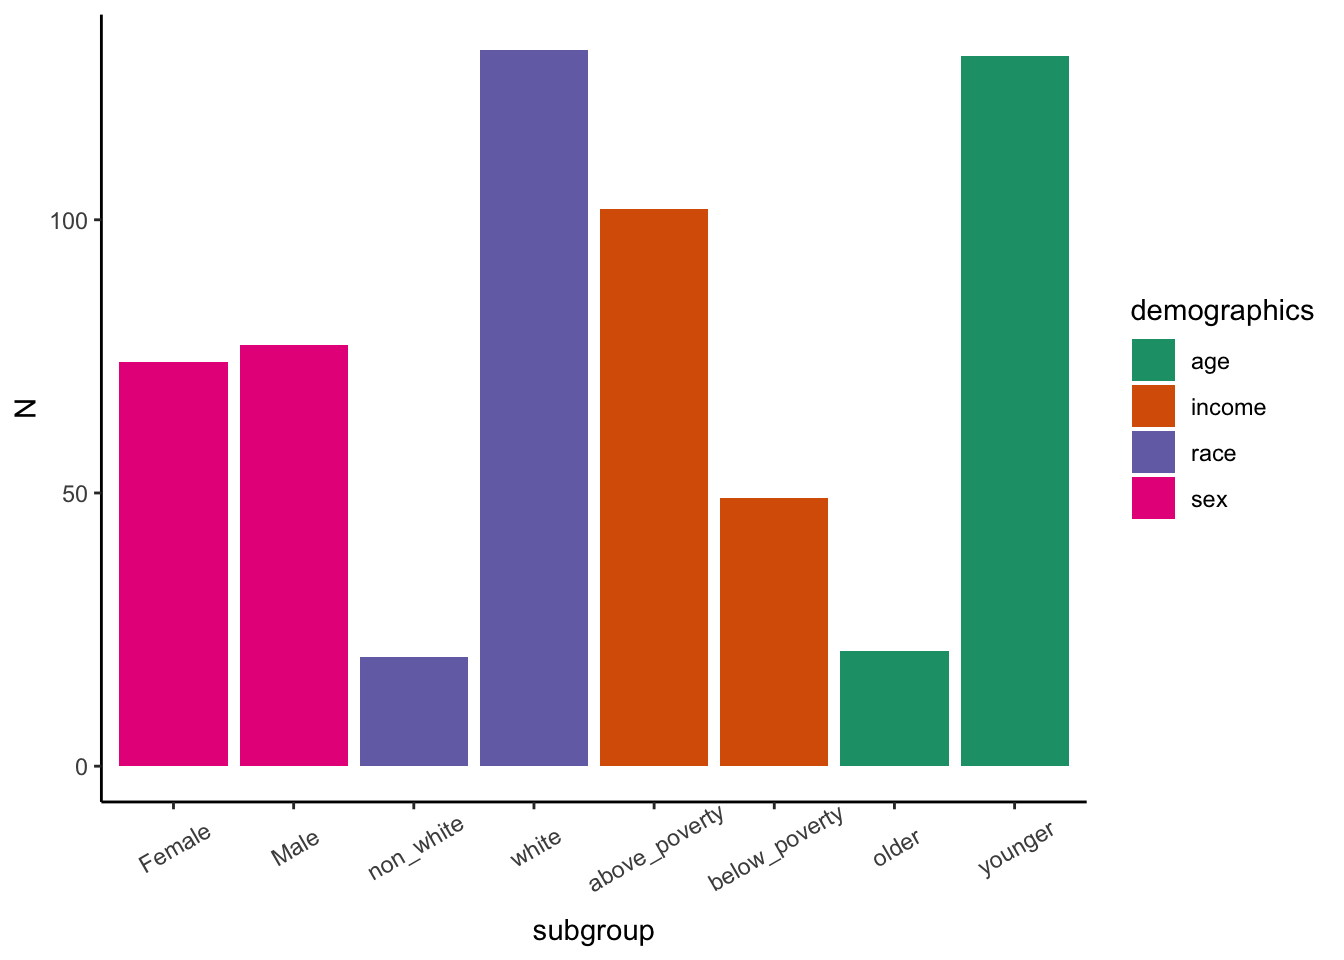

In [ ]:

ggplot(output, aes(subgroup, N, fill=demographics)) +
  geom_col() +
  theme_classic() +
  theme(axis.text.x=element_text(angle = 30, vjust = 0.7)) +
  scale_fill_brewer(palette = "Dark2")


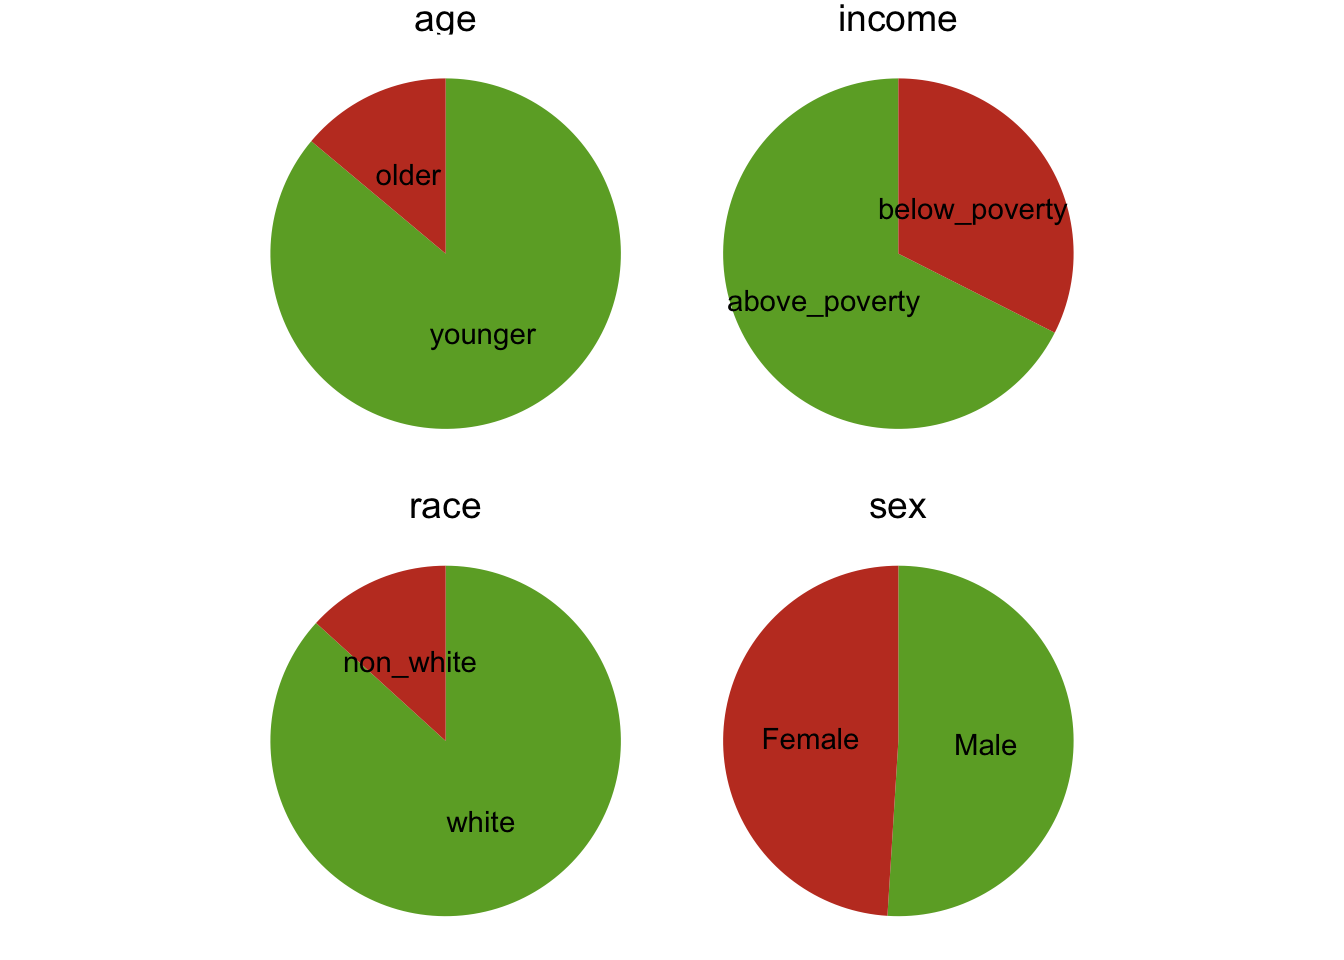

In [ ]:

ggplot(data = output,
       aes(x = "", y = N, fill = subgroup)) + 
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  scale_fill_manual(values = c("Male" = "#6CAA2F",
                               "Female" = "#C23E28",
                               "white" = "#6CAA2F",
                               "non_white" = "#C23E28",
                               "above_poverty" = "#6CAA2F",
                               "below_poverty" = "#C23E28",
                               "younger" = "#6CAA2F",
                               "older" = "#C23E28")) +
  geom_text(aes(label = subgroup), position = position_stack(vjust = 0.5)) +
  theme_void() +
  theme(legend.position="none") +
  facet_wrap(~demographics) +
  theme(strip.text.x = element_text(size = 14))


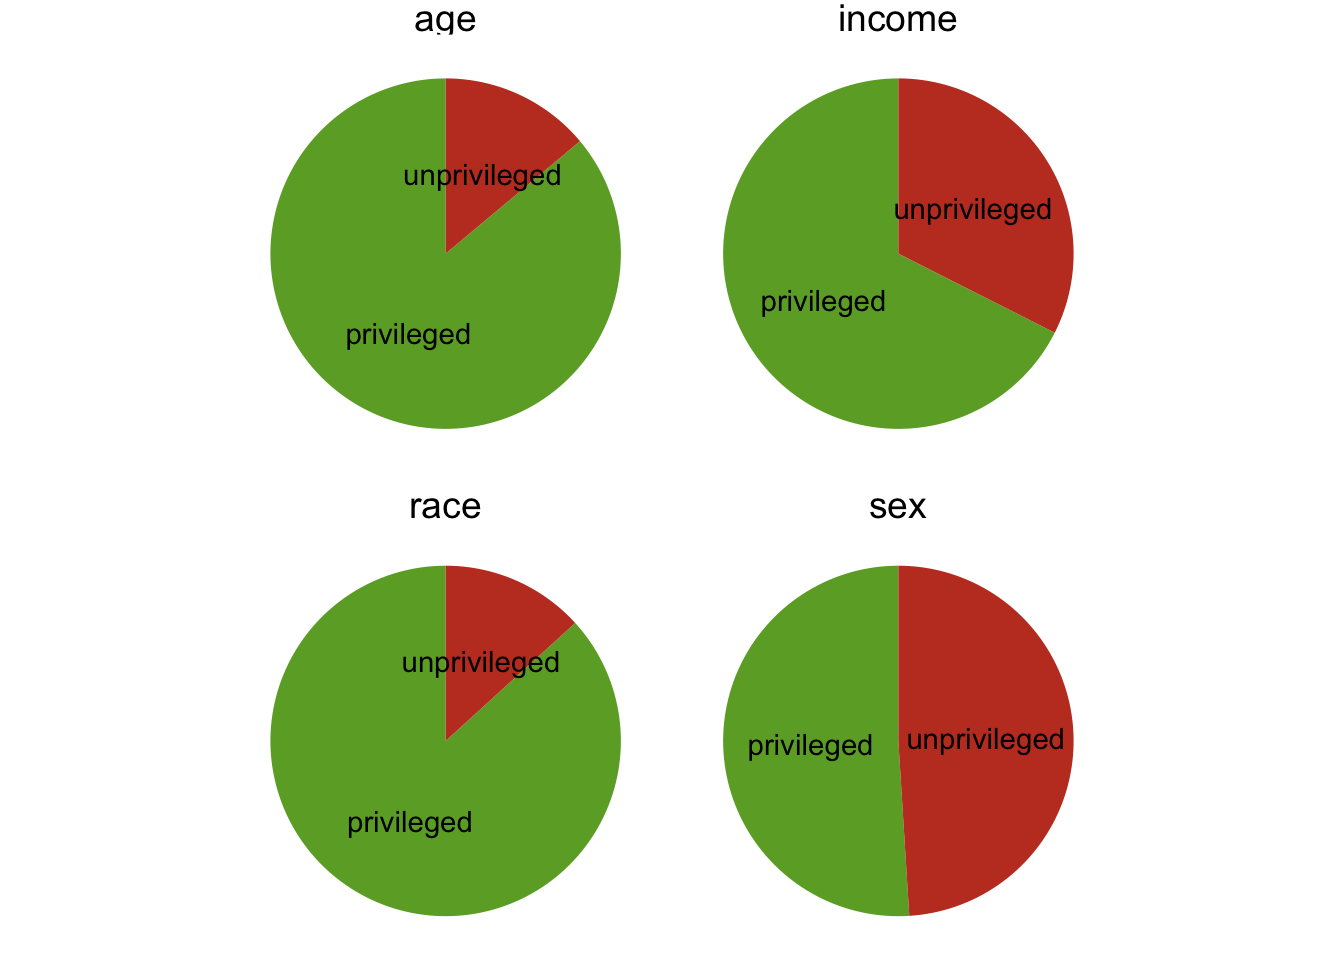

In [ ]:

output |> 
  mutate(
    subgroup = case_when(
      subgroup == "Female" ~ "unprivileged",
      subgroup == "Male" ~ "privileged",
      subgroup == "white" ~ "privileged",
      subgroup == "non_white" ~ "unprivileged",
      subgroup == "above_poverty" ~ "privileged",
      subgroup == "below_poverty" ~ "unprivileged",
      subgroup == "younger" ~ "privileged",
      subgroup == "older" ~ "unprivileged"
    )
  ) |> 
  ggplot(aes(x = "", y = N, fill = subgroup)) + 
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  scale_fill_manual(values = c("privileged" = "#6CAA2F",
                               "unprivileged" = "#C23E28")) +
  geom_text(aes(label = subgroup), position = position_stack(vjust = 0.5)) +
  theme_void() +
  theme(legend.position="none") +
  facet_wrap(~demographics) +
  theme(strip.text.x = element_text(size = 14))


In [ ]:

demo_summary <- function(attribute){
  df <- data.frame(table(demographics[attribute]))
  names(df) <- c("group", "value")
  
  df |> 
  arrange(desc(group)) |> 
  mutate(prop = value / sum(df$value) *100) |> 
  mutate(ypos = cumsum(prop)- 0.5*prop )
}


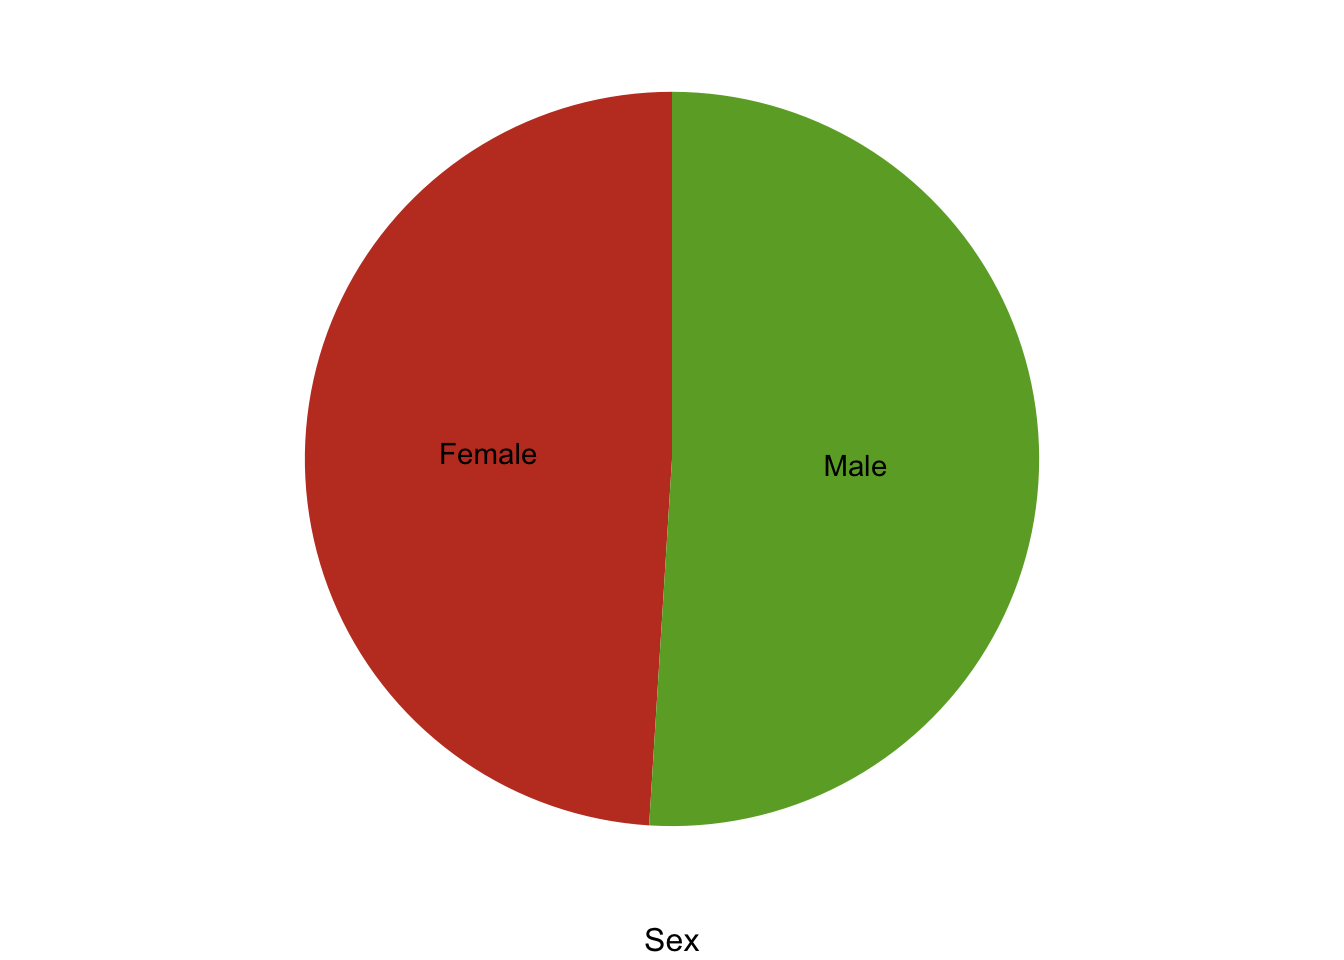

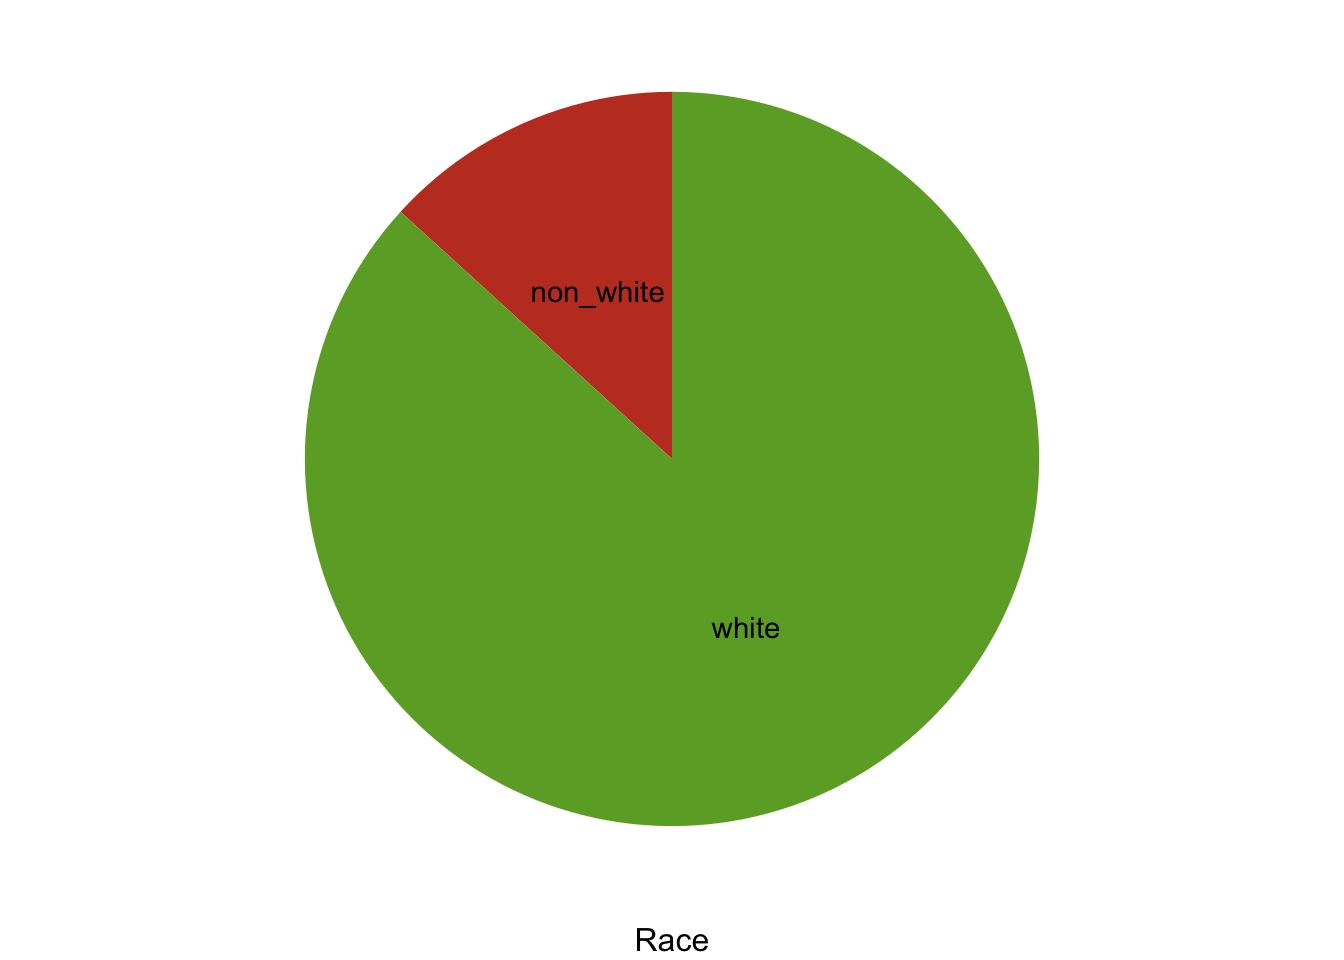

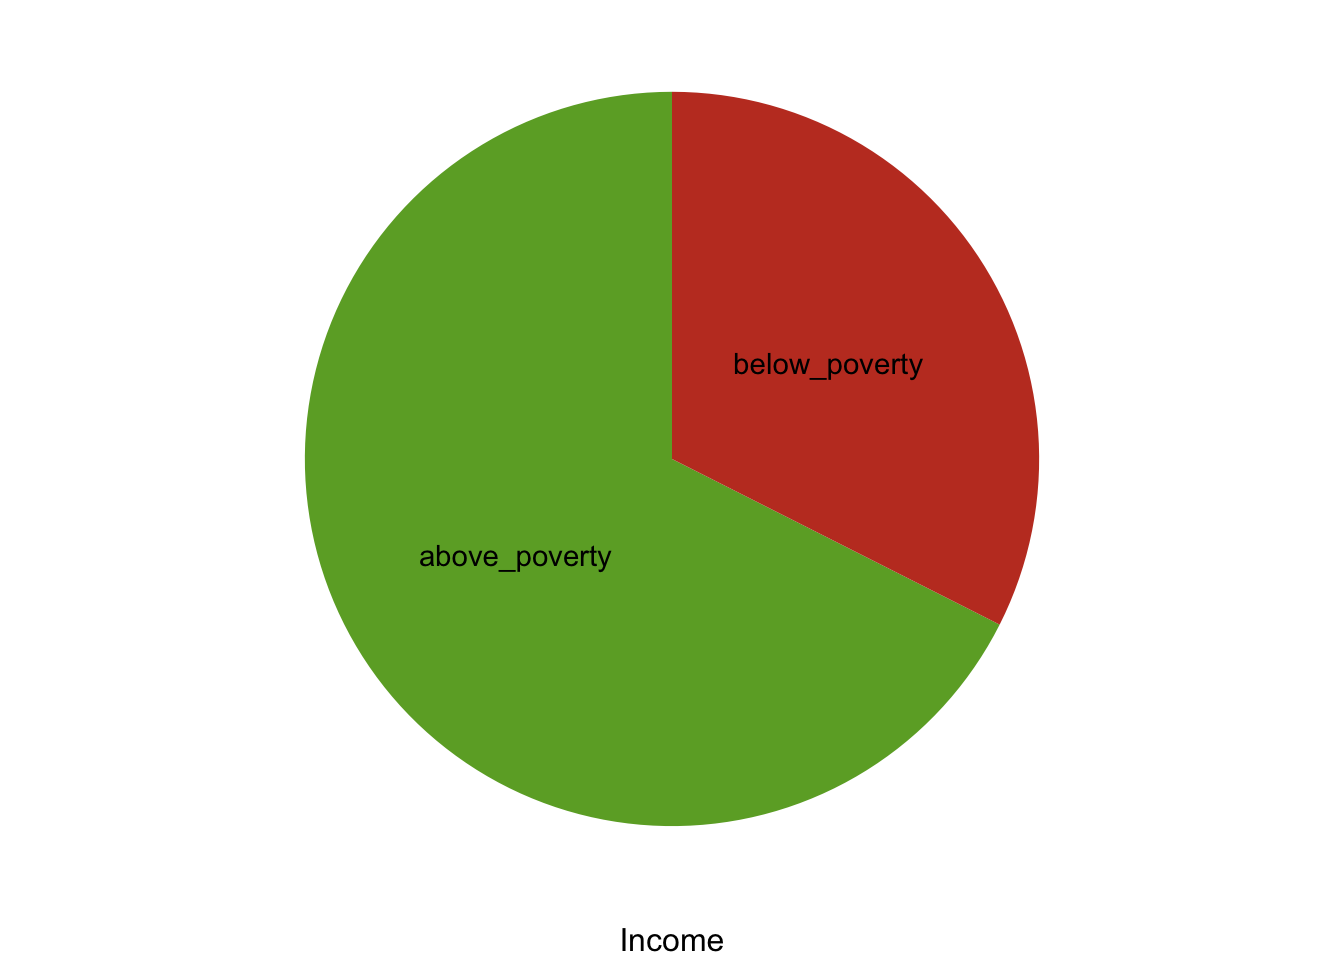

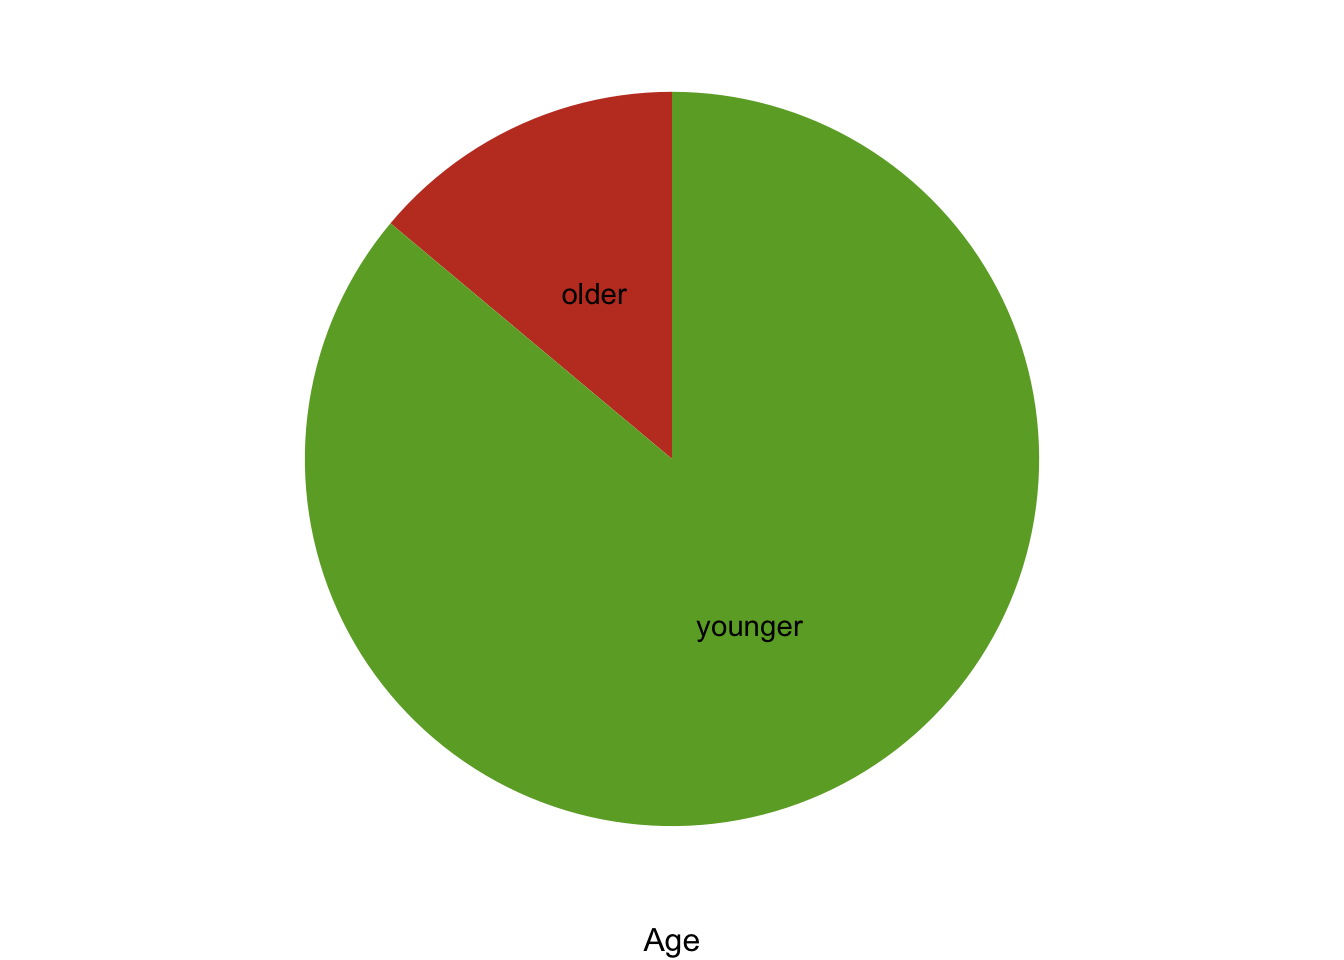

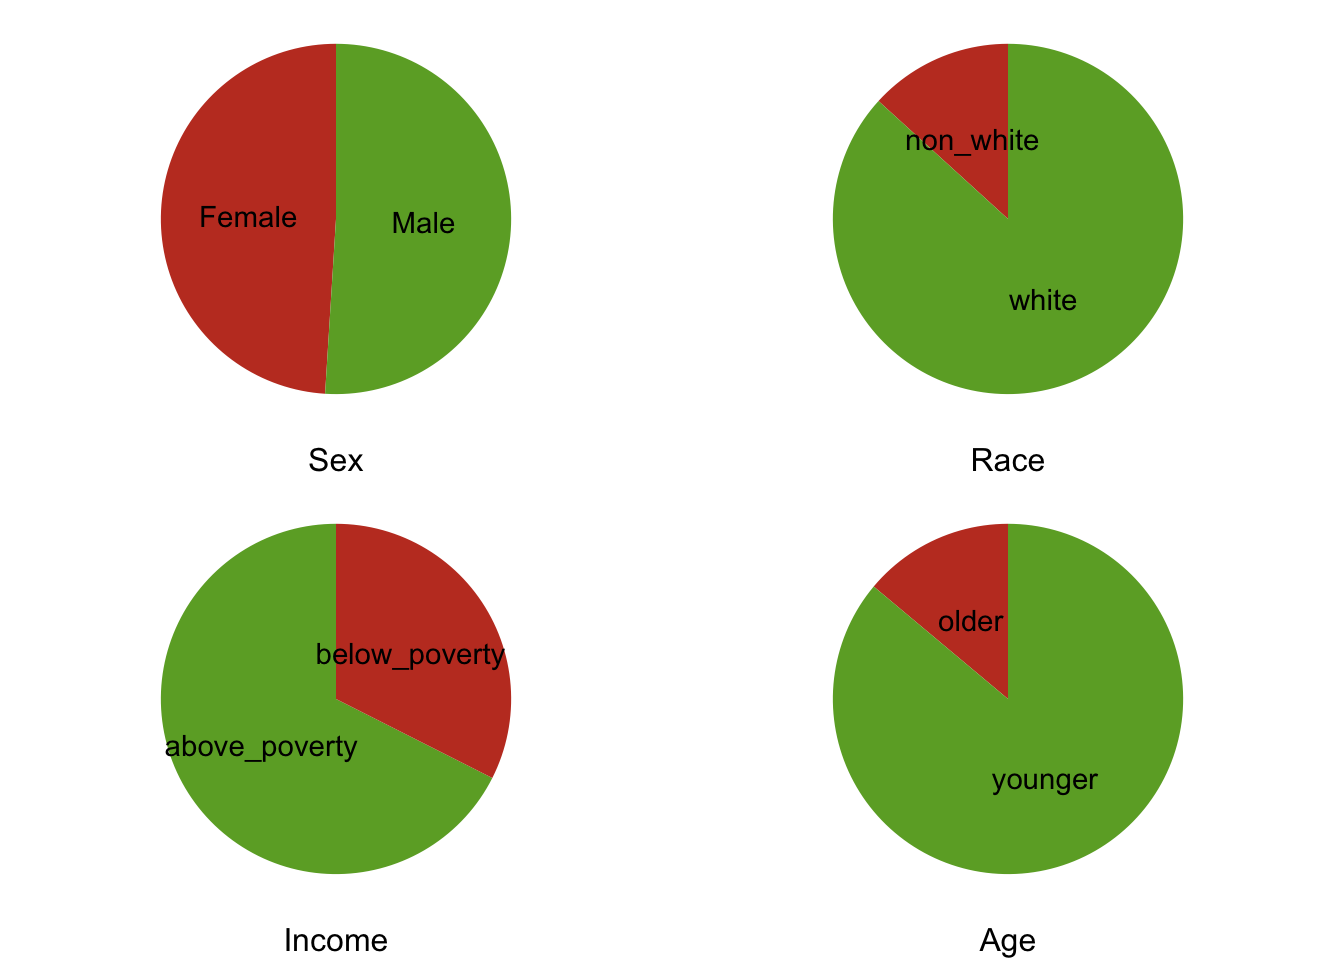

In [ ]:
plot1 <- ggplot(data = data.frame(table(demographics$sex)),
       aes(x = "", y = Freq, fill = Var1)) + 
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  scale_fill_manual(values = c("Male" = "#6CAA2F",
                               "Female" = "#C23E28")) +
  geom_text(aes(label = Var1), position = position_stack(vjust = 0.5)) +
  theme_void() +
  theme(legend.position="none")
plot1 <- gridExtra::grid.arrange(plot1, bottom = "Sex")
